# FIR LPF design

Finite Impulse Response design for Low Pass Filter

June 27, 2018

In [47]:
%matplotlib inline

from numpy import linspace, sin, cos, exp, pi, abs, array, real, int16, append, log10, random
from scipy.io.wavfile import write
from scipy.signal import spectrogram, lfilter
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
from IPython.display import display, Audio

import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

In [57]:
Fs = 100000 # Sampling rate
Fe = 3000  # Cut off frequency

fe = Fe/Fs  # Normalized cut off frequency
delta = Fe*4.0/Fs # Normalized transition bandwidth
print('fe: {} Hz({} Hz), delta: {} Hz'.format(fe, Fe, delta))

fe: 0.03 Hz(3000 Hz), delta: 0.12 Hz


In [58]:
# Hanning window
def hanning_window(N):
    n = linspace(0, N-1, N)
    m = N % 2
    if m == 0:  # even number
        w = 0.5 - 0.5 * cos(2 * pi * n / float(N))        
    elif m == 1:  # odd number
        w = 0.5 - 0.5 * cos(2 * pi * (n + 0.5) / float(N))
    return w

# J + 1: length of Hanning window
def coef_num(delta):
    num = int(round(3.1/delta))
    if (num % 2 == 0):
        num = num + 1
    return num

# Sinc function
def sinc(x):
    if x == 0:
        return 1
    else:
        return sin(x)/x

# FIR coefficients
def coef(m):
    return 2 * fe * sinc(2.0 * pi * fe * m)

In [59]:
WAVE_FILE = './noises.wav'

# Playback chirp signal as tone
def play(wave):
    write(WAVE_FILE, SAMPLING_RATE, real(wave).astype(int16))
    display(Audio('./' + WAVE_FILE))

Number of coefficents: 27


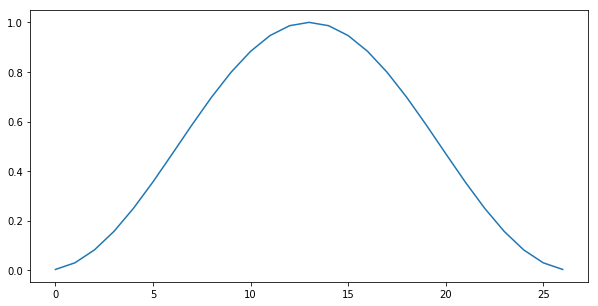

In [60]:
J = coef_num(delta=delta) - 1
print('Number of coefficents: {}'.format(J+1))
w = hanning_window(J+1)
plt.plot(w)

# scipy.signal.windows.hann
#plt.plot(hann(J+1))
#plt.plot(get_window('hann', J+1))

Text(0,0.5,'b')

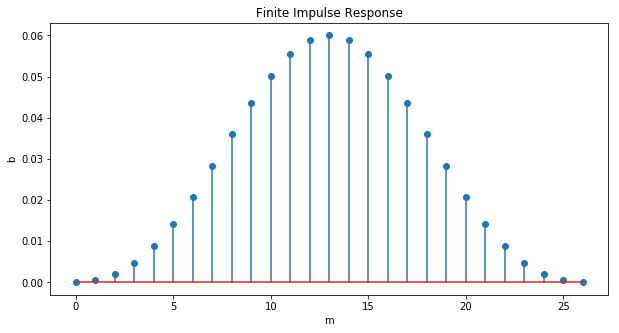

In [61]:
offset = J / 2
m = [i - offset for i in range(J+1)]
b = array([coef(i) for i in m])  # FIR coefficients
plt.stem([i for i in range(J+1)], b * w)
plt.title('Finite Impulse Response')
plt.xlabel('m')
plt.ylabel('b')

## Filtering tone

$$A_4=440 [Hz]$$

$$n = \sum\limits_{n=1}^{7} A_4^n$$

It sounds like pipe organ...

Frequencies at peaks: [-28195.12195122 -14097.56097561  -1756.09756098   -878.04878049
   -439.02439024    439.02439024    878.04878049   1756.09756098
   3512.19512195  14097.56097561  28195.12195122] Hz
Frequencies at peaks: [-1756.09756098  -878.04878049  -439.02439024   439.02439024
   878.04878049  1756.09756098] Hz
Frequencies at peaks: [-1756.09756098  -878.04878049  -439.02439024   439.02439024
   878.04878049  1756.09756098] Hz


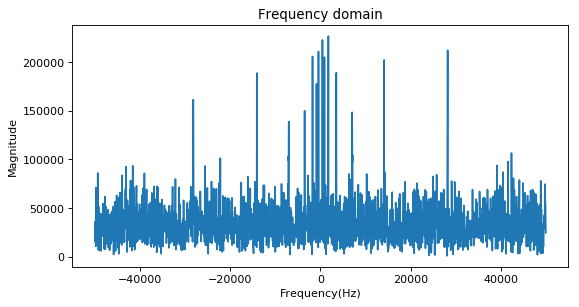

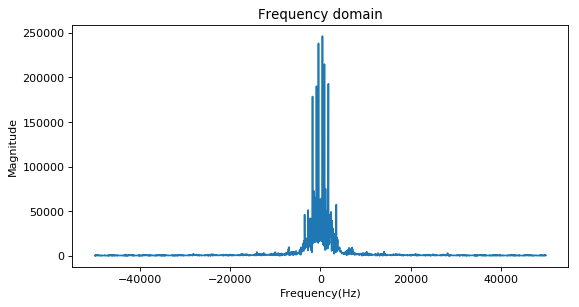

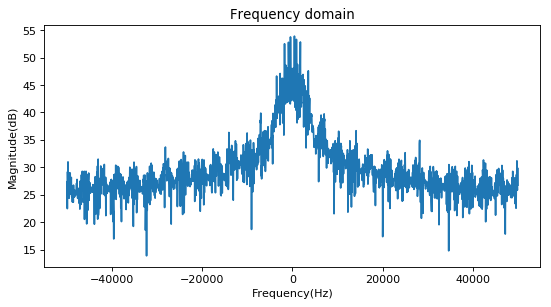

In [66]:
# Constant noise generator
AMPLITUDE = 1000
TIME_FRAME = 0.0205
SAMPLING_RATE = Fs

# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

def constant_tone(f=0, amp=AMPLITUDE, T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    arg = (2 * pi * f * t) * rot + phase
    return cos(arg) * amp


# White noise generator
def white_noise(amp=AMPLITUDE, T=TIME_FRAME):
    a = random.random(int(T * SAMPLING_RATE)) * 2 * amp - amp
    b = random.random(int(T* SAMPLING_RATE)) * 2 * amp - amp
    return a + 1j * b

tone = constant_tone(0)
f = 220  # A3
for i in range(7):
    f = f * 2
    tone = tone + constant_tone(f, amp=200)

    
tone = tone + white_noise()

plot_fft(tone, thres=0.7)

plot_fft(lfilter(b, 1, tone), thres=0.7)

plot_fft(lfilter(b, 1, tone), thres=0.7, logscale=True)

In [64]:
# Noises of A4 ^ n
tone = constant_tone(0, T=2.0)
f = 220  # A3
for i in range(7):
    f = f * 2
    tone = tone + constant_tone(f, T=2.0)
play(tone)

In [40]:
# Filtered tone
tone = lfilter(b, 1, tone)
play(tone)

In [41]:
# Pure A4(440Hz) tone
f = 440
tone = constant_tone(f, T=2.0, amp=5000)
play(tone)

## Output FIR coefficients for TrueSTUDIO

In [95]:
print('float32_t b[{}] = {{'.format(J+1), end='')
print('{0:.8f}'.format(b[-1]), end='')
for i in reversed(b[:-1]):
    print(', {0:.8f}'.format(i), end='')
print('};')

float32_t b[27] = {0.01560757, 0.02043850, 0.02535792, 0.03027307, 0.03508888, 0.03971022, 0.04404423, 0.04800257, 0.05150362, 0.05447453, 0.05685299, 0.05858884, 0.05964532, 0.06000000, 0.05964532, 0.05858884, 0.05685299, 0.05447453, 0.05150362, 0.04800257, 0.04404423, 0.03971022, 0.03508888, 0.03027307, 0.02535792, 0.02043850, 0.01560757};
